In [14]:
# pathを通す（colab対応用にここで分けて書いています）
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [15]:
from typing import Callable, List, Self
import numpy as np
from node import Node
from transition import Transition
from reward import Reward

# 数値文字列を状態として持つNode
class NumberNode(Node):
    def __init__(self, number: str, parent=None, last_action: int=None, last_prob=1.0):
        self.number = number
        super().__init__(parent=parent, last_prob=last_prob, last_action=last_action)

    # それ以上変換できない（しない）かどうかを返す
    def is_terminal(self) -> bool:
        return False

    # 報酬が計算できるノードかどうかを返す
    def has_reward(self) -> bool:
        if self.number == "" or self.number.startswith("0"):
            return False
        else:
            return True
    
    # Nodeを表す文字列を返す（Nodeの一致判定等に使用）
    def key(self) -> str:
        return self.number
    
    # key(self)で出力される文字列からNodeを作成
    # yaml対応が不要な場合はスキップ可能
    @classmethod
    def node_from_key(cls, key: str) -> Self:
        return NumberNode(key)

# 先頭桁に0~9をランダムに追加する変換
class NumberTransition(Transition):
    def transitions_with_probs(self, node: NumberNode) -> list[tuple[int, Node, float]]:
        transitions = []
        for i in range(10):
            next_number = str(i) + node.number
            action = i
            prob = 1 / 10
            next_node = NumberNode(number=next_number, parent=node, last_action=action, last_prob=prob)
            transitions.append((action, next_node, prob))
        return transitions

# 5で割り切れる回数が多く、桁数が小さいほど大きな値を返すReward    
class NumberReward(Reward):
    # パラメータはこのように__init__で定義して使用します（TransitionやFilterでも同様です）
    def __init__(self, scale: float=1.0):
        self.scale = scale    

    # 報酬計算に必要な関数の定義
    def objective_functions(self) -> List[Callable[[NumberNode], float]]:
        # 5で割り切れる回数
        def five_factor_count(node: Node) -> float:
            n = int(node.number)
            count = 0
            while n % 5 == 0 and n > 0:
                n //= 5
                count += 1
            return count
        
        # 桁数
        def length(node: Node) -> float:
            return len(node.number)
        
        return [five_factor_count, length]
    
    # objective_functionsで計算した値をもとに最終的な報酬を計算
    def reward_from_objective_values(self, objective_values: List[float]) -> float:
        two_factor_count = objective_values[0]
        length = objective_values[1]
        return np.tanh(two_factor_count / length / self.scale)

In [16]:
# ↑で定義したNode, Transition, Rewardを使ってMCTS
# node, transition, rewardディレクトリにクラス定義を置いて各フォルダの__init__.pyを編集すれば、sandbox/generation.ipynbのようにyamlから設定を読み込んでの生成が可能になります

from datetime import datetime
import logging
import os
from generator import MCTS
from policy import UCB1
from utils import make_logger

# 生成結果の出力先を指定
output_dir=os.path.join(repo_root, "sandbox/generation_result", datetime.now().strftime("%m-%d_%H-%M")) + os.sep
logger = make_logger(output_dir)

# 探索を開始する根ノード、使用する変換と報酬を定義
root = NumberNode.node_from_key("")
transition = NumberTransition()
reward = NumberReward(scale=1.0)

# policyとgeneratorの定義
policy = UCB1(c=0.01, best_rate=0.5)
generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=None, info_interval=50, output_dir=output_dir, logger=logger)

generator.generate(max_generations=1000)

Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.0000, node: 63
<best reward updated> order: 2, time: 0.00, reward: 0.4621, node: 80
<best reward updated> order: 13, time: 0.00, reward: 0.5828, node: 150
<best reward updated> order: 24, time: 0.00, reward: 0.6351, node: 4750
<best reward updated> order: 38, time: 0.01, reward: 0.8337, node: 31250
<best reward updated> order: 49, time: 0.01, reward: 0.8701, node: 781250
generated: 50, time: 0.01, average over 50: 0.4158
generated: 100, time: 0.02, average over 50: 0.6429
generated: 150, time: 0.03, average over 50: 0.6846
generated: 200, time: 0.04, average over 50: 0.6989
generated: 250, time: 0.05, average over 50: 0.7062
generated: 300, time: 0.06, average over 50: 0.7101
generated: 350, time: 0.08, average over 50: 0.7077
generated: 400, time: 0.10, average over 50: 0.7074
generated: 450, time: 0.12, average over 50: 0.7198
generated: 500, time: 0.14, average over 50: 0.7196
generated: 550, time: 0.16, av

number of generated nodes: 1000
valid rate: 1.0
unique rate: 1.0
node_per_sec: 2608.9821104227312
best_reward: 0.8700616617426719
average_reward: 0.700589631943926


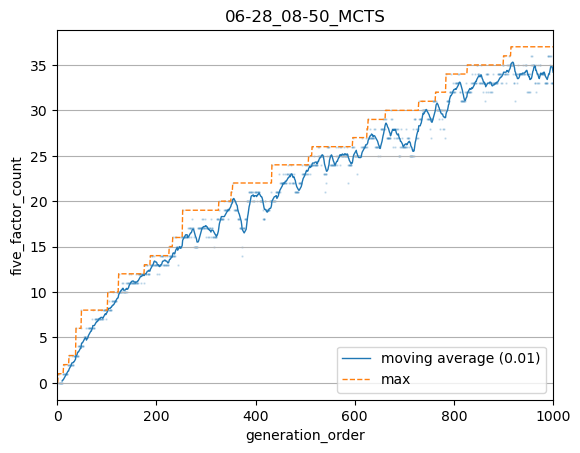

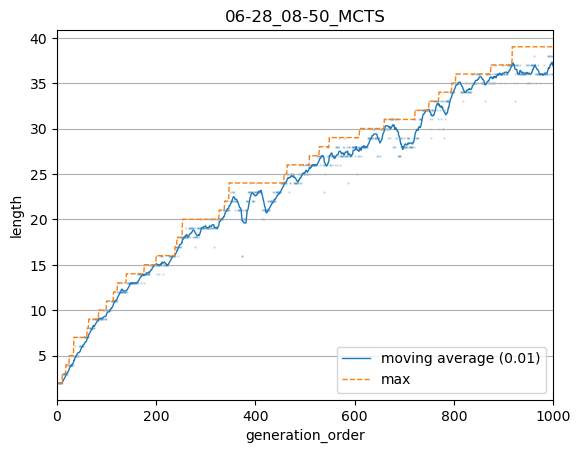

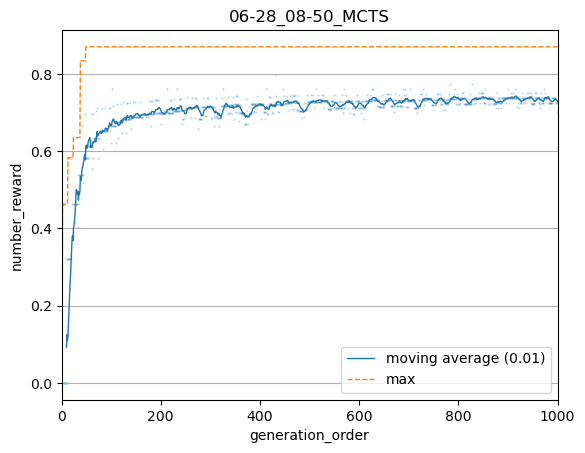

In [17]:
# 生成結果を図示
generator.analyze()
generator.plot(moving_average_window=0.01) # plotを呼ぶと生成結果フォルダにも画像が保存されます